In [69]:
import h5py
import dxchange
import numpy as np
import torch as tc
import torch.nn.functional as tcf
import tomopy
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

In [84]:
# Load projections around a certain angle
_, _, _, theta = dxchange.read_aps_32id('raw/tomo_00001.h5', proj=(0, 1))
n_proj_rad = 5
n_skip = 20
i_theta_cen = len(theta) // 2
prj_ind_range = (i_theta_cen - n_skip * n_proj_rad, i_theta_cen + n_skip * n_proj_rad + 1, n_skip)
prj, flt, drk, theta = dxchange.read_aps_32id('raw/tomo_00001.h5', proj=prj_ind_range)
prj = tomopy.normalize(prj, flt, drk)
prj = tomopy.minus_log(prj)
theta_center = theta[i_theta_cen]
this_theta_ls = theta[slice(*prj_ind_range)]
this_theta_ls = this_theta_ls - theta_center
print(this_theta_ls)

# downsample
prj = zoom(prj, [1, 0.25, 0.25])
print(prj.shape)

[-0.20943951 -0.16755161 -0.12566371 -0.0837758  -0.0418879   0.
  0.0418879   0.0837758   0.12566371  0.16755161  0.20943951]
(11, 448, 512)


## Stretch projection images

In [89]:
def to_numpy(var):
    if var.device.type == 'cpu':
        return var.data.numpy()
    else:
        return var.cpu().data.numpy()

def rescale(x, scale_factor):
    a = tc.tensor([[[1. / scale_factor[1], 0, 0],
                    [0, 1./ scale_factor[0], 0]]])
    a = tcf.affine_grid(a, [1, 1, *prj.shape[1:]])
    try:
        x = tcf.grid_sample(x.reshape([1, 1, *x.shape]), a.double(), align_corners=True, padding_mode='border')
    except:
        x = tcf.grid_sample(x.reshape([1, 1, *x.shape]), a, align_corners=True, padding_mode='border')
    return x[0, 0]

def total_variation(arr, axis_offset=0):
    """
    Calculate total variation of a 3D array.
    :param arr: 3D Tensor.
    :return: Scalar.
    """
    arr_size = 1
    for i in range(len(arr.shape)):
        arr_size = arr_size * arr.shape[i]
    res = tc.sum(tc.abs(tc.roll(arr, 1, dims=0 + axis_offset) - arr))
    res = res + tc.sum(tc.abs(w.roll(arr, 1, dims=1 + axis_offset) - arr))
    res = res / arr_size
    return res

In [86]:
device = None
prj_trans = np.zeros_like(prj)
for i in range(len(this_theta_ls)):
    x = prj[i]
    x = tc.tensor(x, requires_grad=False, device=device)
    x = rescale(x, scale_factor=[1, 1 / np.cos(this_theta_ls[i])])
    x = to_numpy(x)
    prj_trans[i] = x

## Train a branched autoencoder
Define an autoencoder model that takes all selected projection images as input. In addition, pass the latent layer to another CNN and upsample it into a single image with the same dimension as each input projection.  

In [87]:
class BranchedAEModel(tc.nn.Module):
    
    def __init__(self, n_prj, gamma=1.):
        super(BranchedAEModel, self).__init__()
        
        self.gamma = gamma
        
        self.ds_2 = tc.nn.MaxPool2d(2, stride=2, return_indices=True)
        self.us_2 = tc.nn.MaxUnpool2d(2, stride=2)
        self.uz_2 = tc.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv1 = tc.nn.Conv2d(n_prj, n_prj * 2, 3, stride=1, padding_mode='reflect', padding=1)
        self.conv2 = tc.nn.Conv2d(n_prj * 2, n_prj * 4, 3, stride=1, padding_mode='reflect', padding=1)
        self.conv3 = tc.nn.Conv2d(n_prj * 4, n_prj * 4, 3, stride=1, padding_mode='reflect', padding=1)
        self.conv4 = tc.nn.Conv2d(n_prj * 4, n_prj * 4, 3, stride=1, padding_mode='reflect', padding=1)
        
        self.dconv4 = tc.nn.Conv2d(n_prj * 4, n_prj * 4, 3, stride=1, padding_mode='reflect', padding=1)
        self.dconv3 = tc.nn.Conv2d(n_prj * 4, n_prj * 4, 3, stride=1, padding_mode='reflect', padding=1)
        self.dconv2 = tc.nn.Conv2d(n_prj * 4, n_prj * 2, 3, stride=1, padding_mode='reflect', padding=1)
        self.dconv1 = tc.nn.Conv2d(n_prj * 2, n_prj, 3, stride=1, padding_mode='reflect', padding=1)
        
        self.br_conv1 = tc.nn.Conv2d(n_prj * 4, n_prj * 4, 3, stride=1, padding_mode='reflect', padding=1)
        self.br_conv2 = tc.nn.Conv2d(n_prj * 4, n_prj * 2, 3, stride=1, padding_mode='reflect', padding=1)
        self.br_conv3 = tc.nn.Conv2d(n_prj * 2, n_prj, 3, stride=1, padding_mode='reflect', padding=1)
        self.br_conv4 = tc.nn.Conv2d(n_prj, 1, 3, stride=1, padding_mode='reflect', padding=1)
    
    def forward(self, prj):
        """
        ::params prj: Tensor in [1, n, y, x] (i.e., neighboring projections are treated as channels)
        """
        x = self.conv1(prj)
        x, ind1 = self.ds_2(tc.nn.functional.relu(x))
        x = self.conv2(x)
        x, ind2 = self.ds_2(tc.nn.functional.relu(x))
        x = self.conv3(x)
        x, ind3 = self.ds_2(tc.nn.functional.relu(x))
        x = self.conv4(x)
        z, ind4 = self.ds_2(tc.nn.functional.relu(x))
        
        x = self.us_2(tc.nn.functional.relu(z), ind4)
        x = self.dconv4(x)
        x = self.us_2(tc.nn.functional.relu(x), ind3)
        x = self.dconv3(x)
        x = self.us_2(tc.nn.functional.relu(x), ind2)
        x = self.dconv2(x)
        x = self.us_2(tc.nn.functional.relu(x), ind1)
        y_dec = self.dconv1(x)
        
        x = self.uz_2(tc.nn.functional.relu(z))
        x = self.br_conv1(x)
        x = self.uz_2(tc.nn.functional.relu(x))
        x = self.br_conv2(x)
        x = self.uz_2(tc.nn.functional.relu(x))
        x = self.br_conv3(x)
        x = self.uz_2(tc.nn.functional.relu(x))
        y_lat = self.br_conv4(x)
        
        
        return y_dec, y_lat
    
    def get_loss(self, prj):
        y_dec, y_lat = self.forward(prj)
        loss = tc.nn.functional.mse_loss(y_dec, x_prj) #+ self.gamma * tc.mean(tc.abs(y_lat))
        return loss

#device = tc.device('cuda:0')
device = None

x_prj = tc.tensor(prj_trans.reshape([1, len(prj_trans), *prj_trans.shape[-2:]]), device=device)
model = BranchedAEModel(x_prj.shape[1], gamma=1.)
opt = tc.optim.Adam(model.parameters(), 1e-3)

for i_epoch in range(100):
    opt.zero_grad()
    loss = model.get_loss(x_prj)
    loss.backward()
    opt.step()
    if i_epoch % 1 == 0:
        print('{}: {}'.format(i_epoch, to_numpy(loss)))
y_dec, y_lat = model.forward(x_prj)
y_dec = to_numpy(y_dec)[0]
y_lat = to_numpy(y_lat)[0, 0]
dxchange.write_tiff(y_dec, 'rec/y_dec', dtype='float32', overwrite=True)
dxchange.write_tiff(y_lat, 'rec/y_lat', dtype='float32', overwrite=True)

0: 0.13245782256126404
1: 0.1314595639705658
2: 0.13043314218521118
3: 0.1293480396270752
4: 0.12815135717391968
5: 0.12673693895339966
6: 0.12488190829753876
7: 0.12213385850191116
8: 0.11761929094791412
9: 0.10974876582622528
10: 0.09635980427265167
11: 0.07569343596696854
12: 0.05317871272563934
13: 0.07425785809755325
14: 0.059024617075920105
15: 0.042951393872499466
16: 0.04118841141462326
17: 0.04402614012360573
18: 0.04490889608860016
19: 0.04242011159658432
20: 0.03692133352160454
21: 0.030589861795306206
22: 0.027379844337701797
23: 0.030296320095658302
24: 0.03203548863530159
25: 0.026754548773169518
26: 0.02300792559981346
27: 0.02376946620643139
28: 0.02486700937151909
29: 0.02391885407269001
30: 0.021480640396475792
31: 0.019783997908234596
32: 0.02015441283583641
33: 0.021035421639680862
34: 0.020001698285341263
35: 0.018196148797869682
36: 0.018074100837111473
37: 0.018348978832364082
38: 0.017622511833906174
39: 0.01630442962050438
40: 0.01577269285917282
41: 0.01585406

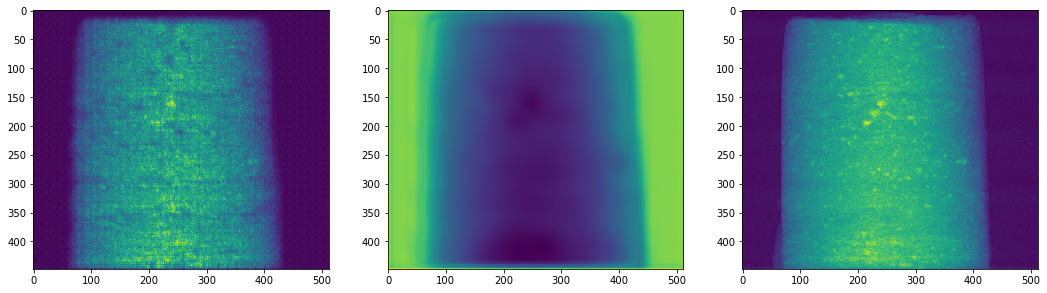

In [88]:
y_dec, y_lat = model.forward(x_prj)
y_dec = to_numpy(y_dec)[0]
y_lat = to_numpy(y_lat)[0, 0]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(y_dec[y_dec.shape[0] // 2])
axes[1].imshow(y_lat)
axes[2].imshow(prj_trans[prj_trans.shape[0] // 2])
dxchange.write_tiff(y_dec, 'rec/y_dec', dtype='float32', overwrite=True)
dxchange.write_tiff(y_lat, 'rec/y_lat', dtype='float32', overwrite=True)
dxchange.write_tiff(prj_trans, 'rec/x_prj', dtype='float32', overwrite=True)